## Simple simulation of basic multi-arm bandit algorithms 

### Strategies tested:
1. Epsilon-greedy: Choose arm randomly based on 'epsilon' probability and exploit with (1-epsilon) probability
2. UCB (Upper confidence bound): Choose arm which has max value, where value is calculated as sample_mean + ucb
    (where ucb is sqrt(log(2*total draws)/draw for arm); as in Chernoff-Hoeffding bound   (https://jeremykun.com/2013/10/28/optimism-in-the-face-of-uncertainty-the-ucb1-algorithm/)
3. Thomson sampling
    
The objective of this simulation is to show, UCB effectively addresses explore-exploit problem, and converges to an optimal solution. Simulation params:
arm_params = {'distribution': 'bernoulli', 'known_arm_probabilities': [0.1, 0.1, 0.1, 0.9]}
Convergence here means, after sufficient draws, 'best arm with conversion probability 0.9 should be picked'

In our context, draws are equivalent of accumulating clicks (considering uncertainty in rpc estimates is governed by amount of data or clicks a particular property, or keyword collect). 

Simulation Methodology:
1. 4 bernoulli arms with known distributions
2. Each simulation run consists of 150 time steps (draw arm per strategy, observe reward, update arm statistics and repeat)
3. Total 100 simulation runs done
4. Avg. reward across all arms (per time step) is graphed below
5. Good MLB algorithm will converge to max reward (here 0.9) gradually. Remember, avg. reward is reward across all arms. So this simulation shows, becuase the "best" arm was getting picked more and more, avg. reward converges to true reward of the best arm. Traditional A/B test would have split traffic equally until each arm drawn 14750 times. So with 150 runs and 100 replications, avg. reward would have been closer to 0.3 (similar to 100% exploration); and we would have shifted traffic 100% to best arm after that.

### TL;DR
1. If arms, in our context properties, with higher conversion rate exist, and for whatever reason in the past we bid too low for them to win any auctions or accumulate any clicks; by uncertainty based exploration, there is good chance we can generate volume for them.

2. This simulation does not consider for cpc (which is direct result of reserve price and second price). We are hoping by effectively utilizing other info-bits like the price competitiveness and the opportunity report, we can identify low competition / low cost properties

In [ ]:
from __future__ import division
from abc import ABCMeta, abstractmethod
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


class BanditArm(object):
    """
    Arm is just one possible control or decision configuration available to us
    (which arm to pick / which action to take)
    This can be a:
        - bernoulli arm (just 1/0 reward like a click or conversion)
    """
    def __init__(self, true_params=None, prior_params=None):

        # True distrbution params
        if true_params:
            self.true_distribution = true_params.get('distribution', 'bernoulli')
            self.p = true_params.get('p', 0.5) # Binom, bernoulli
        else:
            print 'CANNOT PROCEED, Need known arm distributions to proceed'

        # Arm statistics / distribution parameter estimates
        self.trials = 0
        self.sample_mean = 0
        self.prior_alpha, self.prior_beta, self.prior_mu, self.prior_distribution = 1, 1, 1, 'beta'

    def update_trial_count_for_arm(self):
        self.trials += 1

    def observe_reward_for_trial(self):
        """
        Observed reward will be based on true distribution of an arm
        e.g. bernoulli, binomial, poisson, normal, lognormal etc
        """
        self.update_trial_count_for_arm()
        if self.true_distribution == 'bernoulli':
            return np.random.binomial(n=1, p=self.p)

    def update_sample_reward_mean_mle(self, reward):
        """
        Compute simple Maximum likelihood estimate of reward
        For bernoulli, binomial, poisson and gaussian mle estimate of paramter is just sample mean: number_of_successes / number of trials
        Note: we are calculating running avg, (n-1)/n * old_estimate + 1/n * latest_reward
        :param reward:
        :return:
        """
        new_value = (((self.trials - 1) / self.trials) * self.sample_mean) + ((1 / self.trials) * reward)
        self.sample_mean = new_value
        return

    def update_upper_confidence_bound(self, total_trials):
        """
            Compute uncertainty estimate for each arm and update value estimate by mean + uncertainty
            uncertainty estimate = math.sqrt((2*log(total_counts))/arm.count)
            This is really Chernoff-Hoeffding bound (https://jeremykun.com/2013/10/28/optimism-in-the-face-of-uncertainty-the-ucb1-algorithm/)
            and hence the name upper_confidence_bound
        """
        if self.true_distribution == 'bernoulli' or self.true_distribution == 'binomial':
            return self.sample_mean + np.sqrt((2 * np.log(total_trials)) / self.trials) if self.trials > 0 else 0
            
    def update_sample_reward_mean_map(self, reward):
        """
        Compute beta-binomial posterior of reward
        (Beta is conjugate prior of bernoulli/binomial)
        Beta mean = alpha / (alpha+beta)
        :param reward:
        :return:
        """
        if reward > 0:
            self.prior_alpha += 1
        else:
            self.prior_beta += 1
        self.sample_mean = self.prior_alpha / (self.prior_alpha + self.prior_beta)
        return

    def sample_from_posterior_distribution(self):
        """
        If arm true distribution is bernoulli or binomial
        prior distribution is beta, so sample from beta
        :return:
        """
        if self.true_distribution == 'bernoulli' or self.true_distribution == 'binomial':
            return np.random.beta(self.prior_alpha, self.prior_beta)
            
        
class BanditPolicy(object):
    """
    Abstract bandit algorithm
    """
    __metaclass__ = ABCMeta

    def __init__(self, params=0):
        self.params = params
        self.arms = None
        self.total_trials = 0

    def initialize_policy_and_bandit_arms(self, arm_params):
        arm_reward_distribution = arm_params.get('distribution', 'bernoulli')
        self.arms = [BanditArm(true_params={'distribution': arm_reward_distribution, 'p': prob}) for prob in arm_params.get('known_arm_probabilities')]
        self.total_trials = 0
        return

    @abstractmethod
    def select_and_return_best_arm(self):
        pass

    @abstractmethod
    def update_sample_mean_reward_for_selected_arm(self, reward, arm):
        pass

    @abstractmethod
    def return_selection_statistics_for_all_arms(self):
        pass

    def return_idx_for_max_value(self, x):
        return x.index(max(x))

    def test_policy(self, means, num_sims, times):
        results = []
        #self.initialize_policy_and_bandit_arms(means)
        for sim in xrange(num_sims):
            self.initialize_policy_and_bandit_arms(means)

            for t in xrange(times):
                self.total_trials += 1
                chosen_arm = self.select_and_return_best_arm()
                reward = chosen_arm.observe_reward_for_trial()
                self.update_sample_mean_reward_for_selected_arm(reward, chosen_arm)
                result = (self.params, sim, t, chosen_arm.p, reward)
                results.append(result)

        return results
    
class EpsilonGreedy(BanditPolicy):
    """
    Simple epislon greedy
    """
    def return_selection_statistics_for_all_arms(self):
        return [arm.sample_mean for arm in self.arms]

    def select_and_return_best_arm(self):
        if random.random() > self.params:
            x = self.return_selection_statistics_for_all_arms()
            max_idx = self.return_idx_for_max_value(x)
            return self.arms[max_idx]
        else:
            return np.random.choice(self.arms)

    def update_sample_mean_reward_for_selected_arm(self, reward, chosen_arm):
        chosen_arm.update_sample_reward_mean_mle(reward)
        return
    
class UCB1(BanditPolicy):
    """
    Simple UCB variant
    """
    def return_selection_statistics_for_all_arms(self):
        return [arm.update_upper_confidence_bound(self.total_trials) for arm in self.arms]

    def select_and_return_best_arm(self):
        # Make sure each arm gets picked at least once
        for arm in self.arms:
            if arm.trials == 0:
                return arm

        x = self.return_selection_statistics_for_all_arms()
        max_idx = self.return_idx_for_max_value(x)
        return self.arms[max_idx]

    def update_sample_mean_reward_for_selected_arm(self, reward, chosen_arm):
        chosen_arm.update_sample_reward_mean_mle(reward)
        return    
    
class ThompsonSampling(BanditPolicy):
    # Start with alpha and beta
    # For each arm, draw arm based on beta(alpha, beta)
    # Choose arm such that, max reward, keep count of success and failuer
    # update beta params for each arm
    # continue
    def return_selection_statistics_for_all_arms(self):
        return [arm.sample_from_posterior_distribution() for arm in self.arms]

    def select_and_return_best_arm(self):
        """
        Select arm with max estimated map mean
        :return:
        """
        samples = self.return_selection_statistics_for_all_arms()
        max_id = self.return_idx_for_max_value(samples)
        return self.arms[max_id]

    def update_sample_mean_reward_for_selected_arm(self, reward, chosen_arm):
        chosen_arm.update_sample_reward_mean_map(reward)
        return
    
    
def run_bandit_algorithm_and_generate_results(policy_name, params=[], sim_nums=1000, times=250):
    random.seed(1)
    arm_params = {'distribution': 'bernoulli', 'known_arm_probabilities': [0.1, 0.1, 0.1, 0.9]}
    final = []
    params = params if params else [0]
    policy = None

    for param in params:
        if policy_name == 'epsilon_greedy':
            policy = EpsilonGreedy(param)

        elif policy_name == 'ucb1':
            policy = UCB1()
            
        elif policy_name == 'thompson_sampling':
            policy = ThompsonSampling()          

        results = policy.test_policy(arm_params, sim_nums, times)
        final.extend(results)

    df = pd.DataFrame(final, columns=['epsilon', 'sim_nums', 'times', 'chosen_arms', 'rewards'])
    grouped_df = pd.DataFrame(df.groupby(['epsilon', 'times'])['rewards'].sum(), columns=['rewards'])
    grouped_df['avg_reward'] = grouped_df['rewards'] / sim_nums

    return grouped_df    


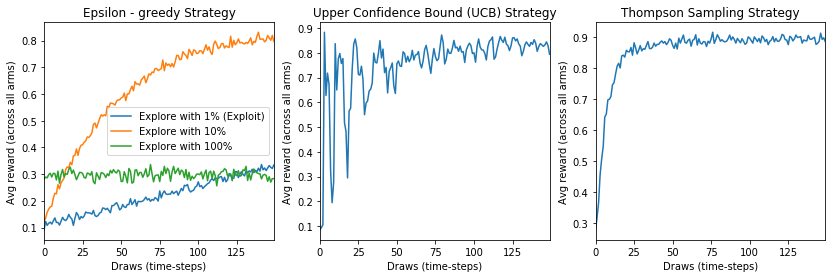

In [25]:
# 100, 250
df = run_bandit_algorithm_and_generate_results(policy_name='epsilon_greedy', params=[0.01, 0.1, 1], 
                                                                     sim_nums=1000, times=150)
df.reset_index(inplace=True)

ucb_df = run_bandit_algorithm_and_generate_results(policy_name='ucb1', sim_nums=1000, times=150)
ucb_df.reset_index(inplace=True)
ucb_df.set_index('times', inplace=True)

thompson_df = run_bandit_algorithm_and_generate_results(policy_name='thompson_sampling', sim_nums=1000, times=150)
thompson_df.reset_index(inplace=True)
thompson_df.set_index('times', inplace=True)

# Draw results of runs
fig, ax = plt.subplots(1,3, figsize=(14,4))
ax[0].set_title('Epsilon - greedy Strategy')
df.loc[df.epsilon==0.01, ['times', 'avg_reward']].set_index('times').rename(columns={'avg_reward': 'Explore with 1% (Exploit)'}).plot(ax=ax[0])
df.loc[df.epsilon==0.1, ['times', 'avg_reward']].set_index('times').rename(columns={'avg_reward': 'Explore with 10%'}).plot(ax=ax[0])
df.loc[df.epsilon==1, ['times', 'avg_reward']].set_index('times').rename(columns={'avg_reward': 'Explore with 100%'}).plot(ax=ax[0])
ax[0].set_xlabel('Draws (time-steps)')
ax[0].set_ylabel('Avg reward (across all arms)') 

ax[1].set_title('Upper Confidence Bound (UCB) Strategy')
ucb_df['avg_reward'].plot(ax=ax[1])
ax[1].set_xlabel('Draws (time-steps)')
ax[1].set_ylabel('Avg reward (across all arms)')

ax[2].set_title('Thompson Sampling Strategy')
thompson_df['avg_reward'].plot(ax=ax[2])
ax[2].set_xlabel('Draws (time-steps)')
ax[2].set_ylabel('Avg reward (across all arms)')